In [1]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import scipy.stats as st
import random
from datetime import datetime

/home/brenna/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
cur_dir = os.path.dirname('__file__')

train = pd.read_csv(os.path.join(cur_dir, "data", "train.csv"))
test = pd.read_csv(os.path.join(cur_dir, "data", "test.csv"))
mapdata = np.loadtxt(os.path.join(cur_dir, "data", "sf_map.txt"))

In [43]:
def get_random_subset(df, n=5000):
    sub = random.sample(xrange(len(df)), min(n, len(df)))
    return df.iloc[sub]

def preprocess(df):
    res = df.copy()
    res = res[res.X != res.X.max()]
    datetimes = res.Dates.apply(get_datetime)
    res['Hour'] = datetimes.apply(lambda dt: dt.hour)
    res['Month'] = datetimes.apply(lambda dt: dt.month)
    res['Hour_Minutes'] = datetimes.apply(lambda dt: dt.hour + dt.minute / 60.0)
    res['Minutes_Since_03'] = datetimes.apply(lambda dt: (dt-datetime(2003, 1, 1)).total_seconds() / 60)
    res['Minutes_Since_New_Year'] = datetimes.apply(lambda dt: (dt-datetime(dt.year, 1, 1)).total_seconds() / 60)
    res['DOW'] = train.DayOfWeek.apply(lambda x: dow.index(x))
    return res

def get_datetime(s):
    dt = datetime.strptime(s, "%Y-%m-%d %H:%M:%S")
    return dt

dow = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def isNight(hour):
    if hour in [0, 1, 2, 3, 4, 5, 6, 19, 20, 21, 22, 23]:
        return "Night"
    else:
        return "Day"

In [4]:
train = preprocess(train)

In [5]:
print train.Category.value_counts()

LARCENY/THEFT                  174885
OTHER OFFENSES                 126165
NON-CRIMINAL                    92300
ASSAULT                         76872
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53772
VANDALISM                       44724
WARRANTS                        42206
BURGLARY                        36754
SUSPICIOUS OCC                  31412
MISSING PERSON                  25989
ROBBERY                         22999
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7325
STOLEN PROPERTY                  4539
SEX OFFENSES FORCIBLE            4387
DISORDERLY CONDUCT               4318
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

/home/brenna/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


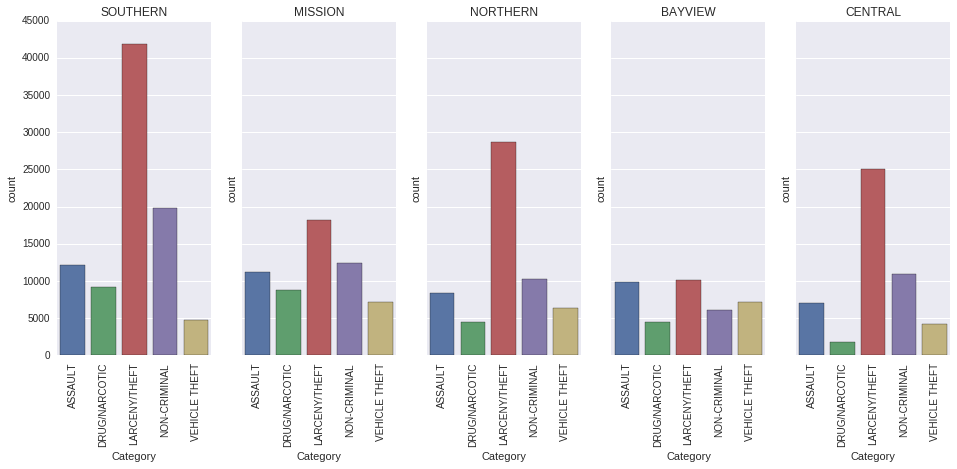

In [6]:
most_common_cats = train.Category[train.Category != "OTHER OFFENSES"].value_counts().index[0:5]
most_common_districts = train.PdDistrict.value_counts().index[0:5]


f, axtuple = plt.subplots(1, len(most_common_cats), sharey=True)

for i in range(len(most_common_districts)):
    
    subset = train[(train.PdDistrict == most_common_districts[i]) & train.Category.isin(most_common_cats)]
    
    ax = sns.countplot(x="Category", data=subset.sort_values("Category"), ax=axtuple[i])
    ax.set_title(most_common_districts[i])
    plt.sca(ax)
    plt.xticks(rotation=90)
    
plt.gcf().set_size_inches(16, 6, forward=True)


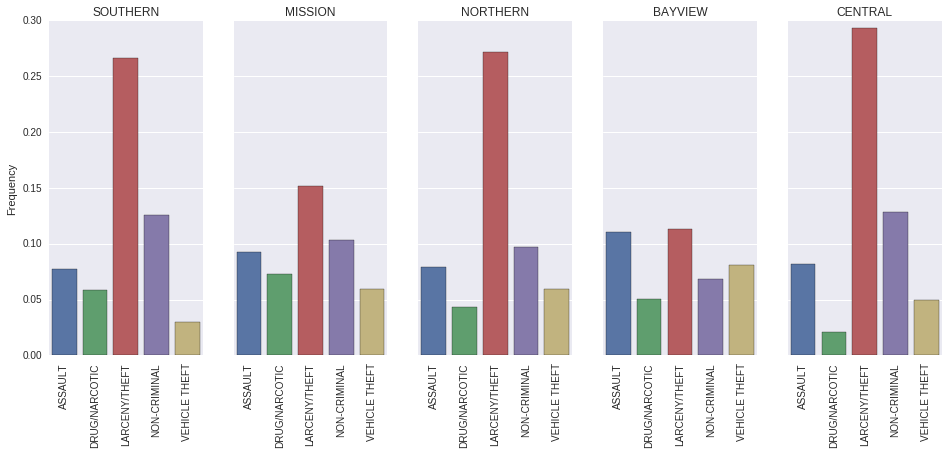

In [7]:
most_common_cats = train.Category[train.Category != "OTHER OFFENSES"].value_counts().index[0:5]
most_common_districts = train.PdDistrict.value_counts().index[0:5]


f, axtuple = plt.subplots(1, len(most_common_cats), sharey=True)


for i in range(len(most_common_districts)):
    
    subset = train[train.PdDistrict == most_common_districts[i]]
    proportions = (subset.Category.value_counts().astype(float) / len(subset)).loc[most_common_cats]
    proportions = proportions.sort_index()
    
    
    
    ax = sns.barplot(x=proportions.index, y=proportions, ax=axtuple[i])
    ax.set_title(most_common_districts[i])
    ax.set_ylabel("")
    plt.sca(ax)
    plt.xticks(rotation=90)
    
axtuple[0].set_ylabel("Frequency")
plt.gcf().set_size_inches(16, 6, forward=True)


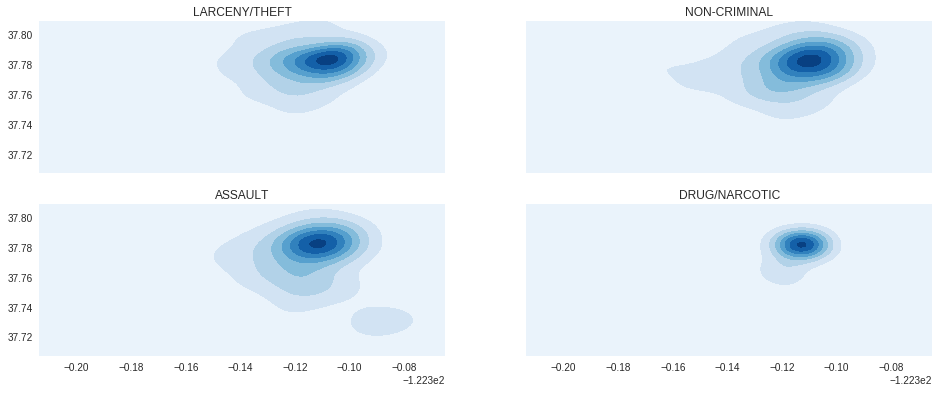

In [8]:
cats = [['LARCENY/THEFT', 'NON-CRIMINAL'], ['ASSAULT', 'DRUG/NARCOTIC']]

train_subset = train[train.Category.isin(sum(cats, []))]  # sum(cats, []) converts a 2d list into a 1d list.

train_subset = get_random_subset(train_subset)

xmin, xmax = train_subset.X.min(), train_subset.X.max()
ymin, ymax = train_subset.Y.min(), train_subset.Y.max()

f, axtuple = plt.subplots(2, 2, sharey=True, sharex=True)

rows, cols = axtuple.shape

for j in range(rows):
    
    for i in range(cols):

        subset = train_subset[train_subset.Category == cats[j][i]]

        x = subset.X
        y = subset.Y

        # Peform the kernel density estimate
        xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([x, y])
        kernel = st.gaussian_kde(values)
        f = np.reshape(kernel(positions).T, xx.shape)
        ax = axtuple[j, i]
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_title(cats[j][i])
        cfset = ax.contourf(xx, yy, f, cmap='Blues')
#         cset = ax.contour(xx, yy, f, colors='k')
#         ax.clabel(cset, inline=1, fontsize=10)
    

plt.gcf().set_size_inches(16, 6, forward=True)

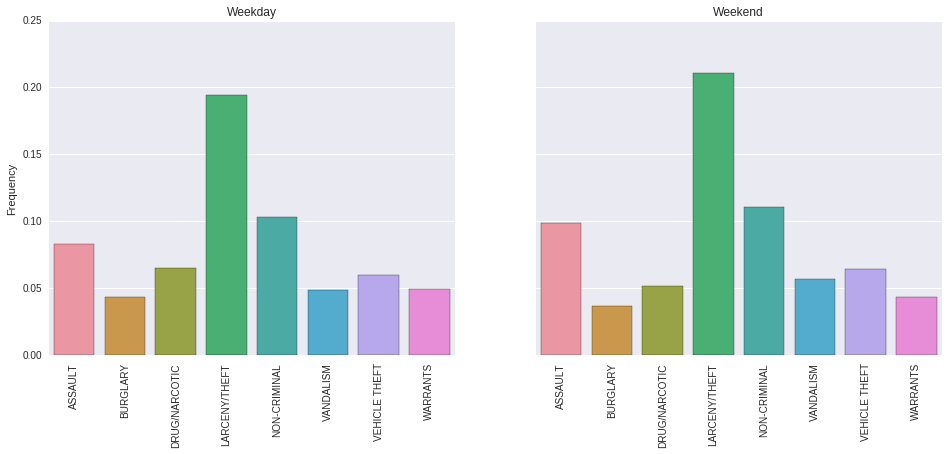

In [9]:
most_common_cats = train.Category[train.Category != "OTHER OFFENSES"].value_counts().index[0:8]
day_counts = train.DayOfWeek.value_counts().index[0:7]

def isWeekend(day):
    if day in ["Saturday", "Sunday"]:
        return "Weekend"
    else:
        return "Weekday"


train["Weekend"] = train["DayOfWeek"].apply(isWeekend)

day_type_counts = train.Weekend.value_counts().index

f, axtuple = plt.subplots(1, len(day_type_counts), sharey=True)


for i, day in enumerate(day_type_counts):
    
    subset = train[train.Weekend == day]
    proportions = (subset.Category.value_counts().astype(float) / len(subset)).loc[most_common_cats]
    proportions = proportions.sort_index()
    
    ax = sns.barplot(x=proportions.index, y=proportions, ax=axtuple[i])
    ax.set_title(day)
    ax.set_ylabel("")
    plt.sca(ax)
    plt.xticks(rotation=90)
    
axtuple[0].set_ylabel("Frequency")
plt.gcf().set_size_inches(16, 6, forward=True)

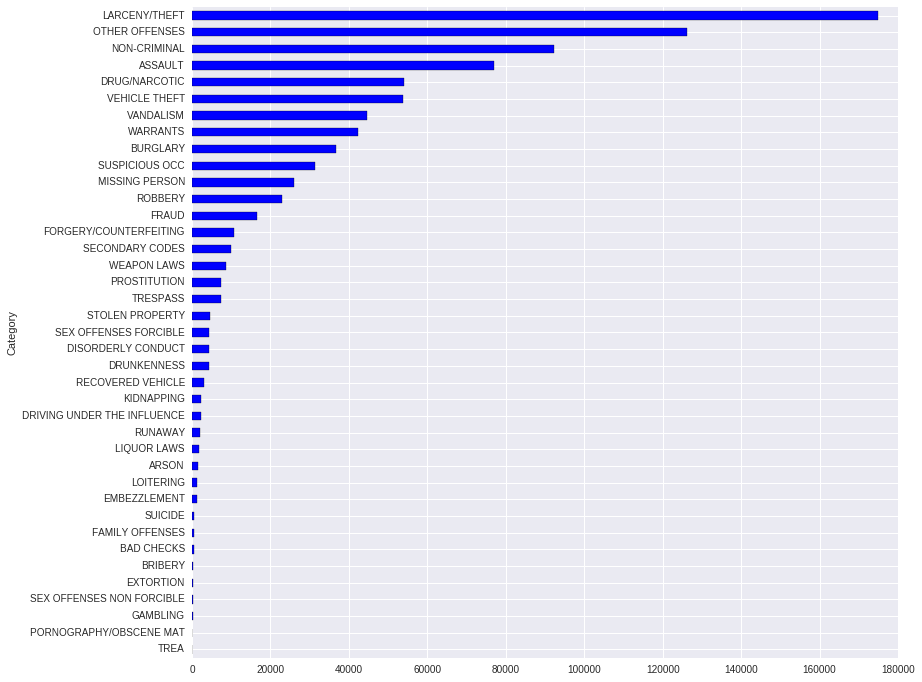

In [10]:
def plot_Category(df):
    cat_Count = df.groupby("Category").count()
    plt.figure()
    cat_Count.sort_values(by="Dates", ascending=1)["Dates"].plot(kind="barh")
    plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
    plt.tight_layout()
    plt.gcf().set_size_inches(16, 10, forward=True)
    
plot_Category(train)

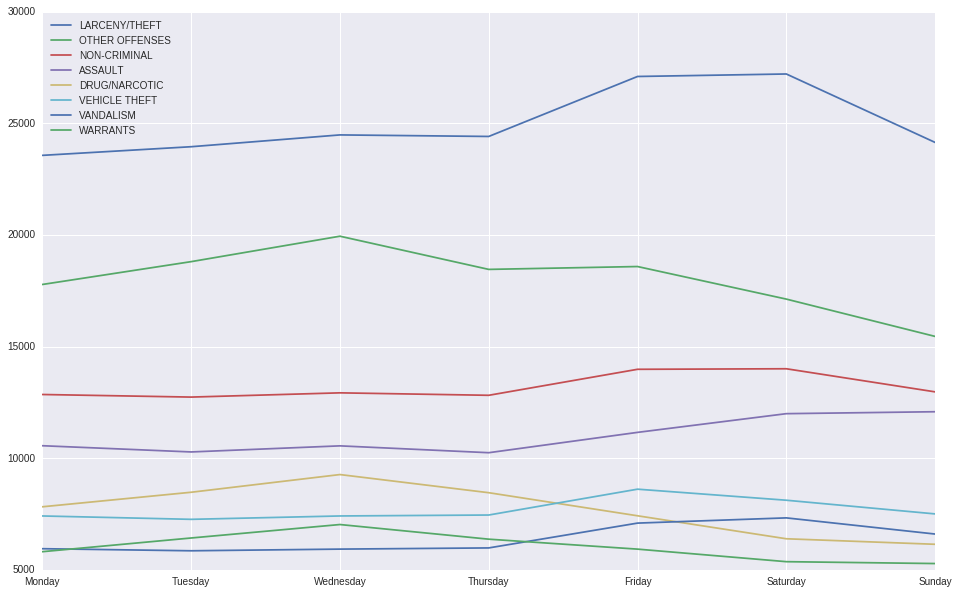

In [11]:
categories = train.Category.value_counts().index[0:8]
bins = np.arange(0,7, 1)
for c in categories:
    subset = train[train.Category == c]
    indices = np.digitize(subset.DOW, bins)
    groups = subset.groupby(indices)
    days = [g.DOW.mean() for _, g in groups]
    crimes = [len(g) for _, g in groups]
    plt.plot(days, crimes, label=c)
plt.legend(loc=2)
plt.gcf().set_size_inches(16, 10, forward=True)
plt.gca().set_xticklabels(dow)

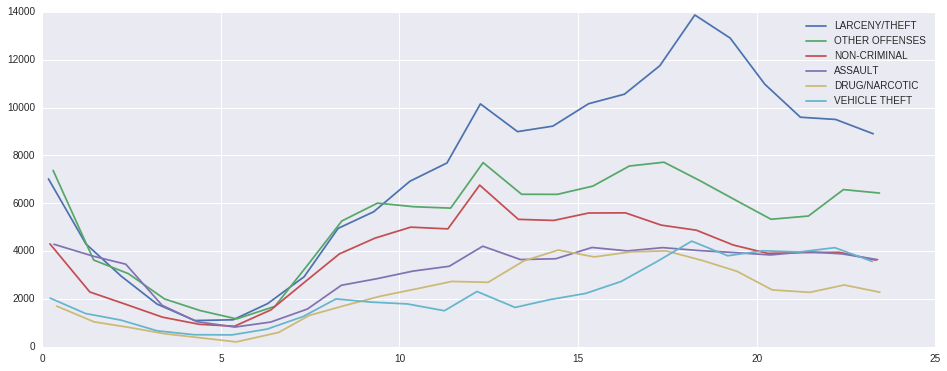

In [12]:

categories = train.Category.value_counts().index[0:6]
bins = np.arange(1, 24, 1)
for c in categories:
    subset = train[train.Category == c]
    indices = np.digitize(subset.Hour_Minutes, bins)
    groups = subset.groupby(indices)
    times = [g.Hour_Minutes.mean() for i, g in groups]
    crimes = [len(g) for i, g in groups]
    plt.plot(times, crimes, label=c)
plt.legend()
plt.gcf().set_size_inches(16, 6, forward=True)

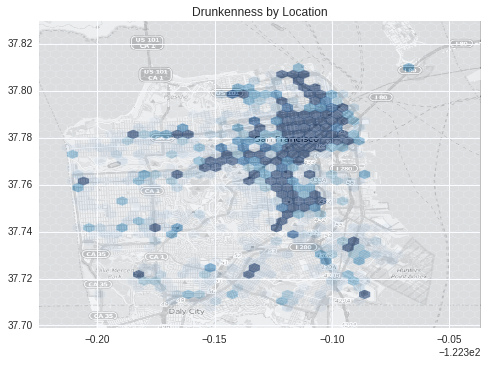

In [16]:
train_subset = get_random_subset(train[train[train.Category == "DRUNKENNESS"].)

lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)

imgplot = plt.imshow(mapdata, cmap=plt.get_cmap('gray'),extent=lon_lat_box)
plt.hexbin(train_subset.X, train_subset.Y, gridsize=40, cmap=plt.cm.Greens,
           extent=lon_lat_box, alpha=0.5, vmin=0, vmax=10)
plt.title('Drunkenness by Location')
# ax.axis(lon_lat_box)

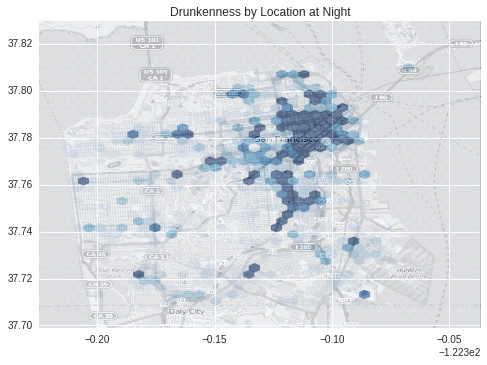

In [38]:
train_subset = get_random_subset(train[train.Category == "DRUNKENNESS"])
train_subset.Hour = train_subset.Hour.astype(float)



train_subset["NightOrDay"] = train["Hour"].apply(isNight)
train_subset_night = train_subset[train_subset.NightOrDay == "Night"]
train_subset_day = train_subset[train_subset.NightOrDay == "Day"]
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)

imgplot = plt.imshow(mapdata, cmap=plt.get_cmap('gray'),extent=lon_lat_box)
plt.hexbin(train_subset_night.X, train_subset_night.Y, gridsize=40, cmap=plt.cm.Blues,
           extent=lon_lat_box, alpha=0.5, vmin=0, vmax=10)

plt.title('Drunkenness by Location at Night')
# ax.axis(lon_lat_box)

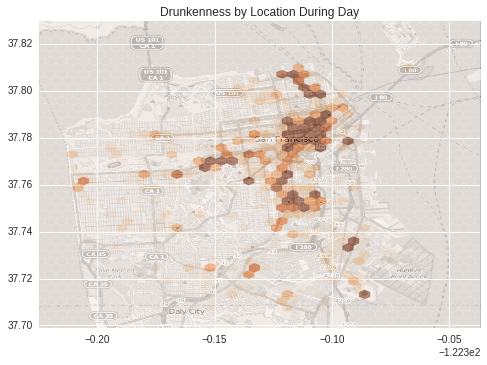

In [39]:
imgplot = plt.imshow(mapdata, cmap=plt.get_cmap('gray'),extent=lon_lat_box)
plt.hexbin(train_subset_day.X, train_subset_day.Y, gridsize=40, cmap=plt.cm.Oranges,
           extent=lon_lat_box, alpha=0.5, vmin=0, vmax=10)

plt.title('Drunkenness by Location During Day')


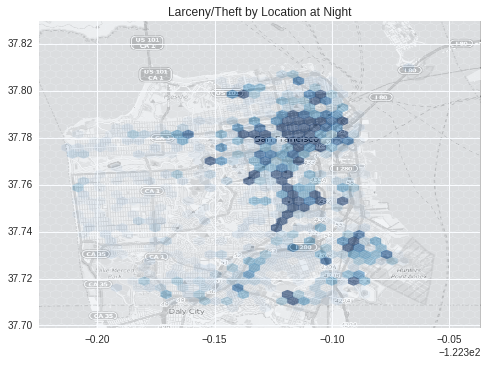

In [41]:
train_subset = get_random_subset(train[train.Category == "ASSAULT"])
train_subset.Hour = train_subset.Hour.astype(float)


train_subset["NightOrDay"] = train["Hour"].apply(isNight)
train_subset_night = train_subset[train_subset.NightOrDay == "Night"]
train_subset_day = train_subset[train_subset.NightOrDay == "Day"]
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)

imgplot = plt.imshow(mapdata, cmap=plt.get_cmap('gray'),extent=lon_lat_box)
plt.hexbin(train_subset_night.X, train_subset_night.Y, gridsize=40, cmap=plt.cm.Blues,
           extent=lon_lat_box, alpha=0.5, vmin=0, vmax=10)

plt.title('Assaults by Location at Night')


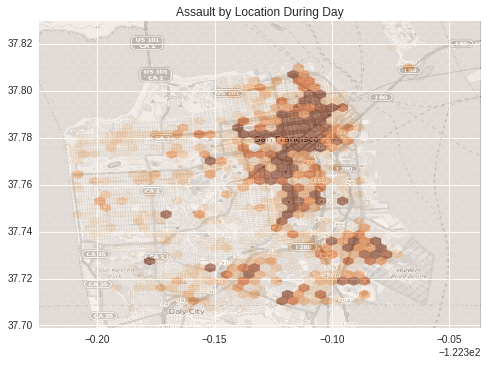

In [36]:
imgplot = plt.imshow(mapdata, cmap=plt.get_cmap('gray'),extent=lon_lat_box)
plt.hexbin(train_subset_day.X, train_subset_day.Y, gridsize=40, cmap=plt.cm.Oranges,
           extent=lon_lat_box, alpha=0.5, vmin=0, vmax=10)

plt.title('Assault by Location During Day')


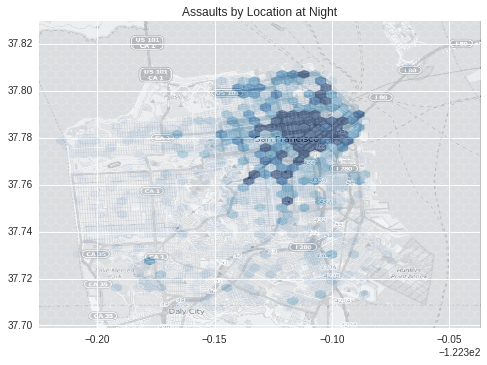

In [40]:
train_subset = get_random_subset(train[train.Category == "LARCENY/THEFT"])
train_subset.Hour = train_subset.Hour.astype(float)



train_subset["NightOrDay"] = train["Hour"].apply(isNight)
train_subset_night = train_subset[train_subset.NightOrDay == "Night"]
train_subset_day = train_subset[train_subset.NightOrDay == "Day"]
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)

imgplot = plt.imshow(mapdata, cmap=plt.get_cmap('gray'),extent=lon_lat_box)
plt.hexbin(train_subset_night.X, train_subset_night.Y, gridsize=40, cmap=plt.cm.Blues,
           extent=lon_lat_box, alpha=0.5, vmin=0, vmax=10)

plt.title('Larceny/Theft by Location at Night')


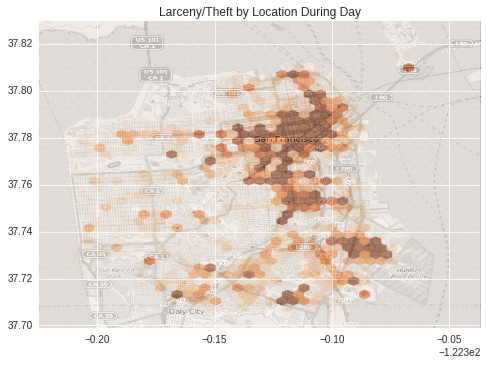

In [44]:
imgplot = plt.imshow(mapdata, cmap=plt.get_cmap('gray'),extent=lon_lat_box)
plt.hexbin(train_subset_day.X, train_subset_day.Y, gridsize=40, cmap=plt.cm.Oranges,
           extent=lon_lat_box, alpha=0.5, vmin=0, vmax=10)

plt.title('Larceny/Theft by Location During Day')


/home/brenna/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


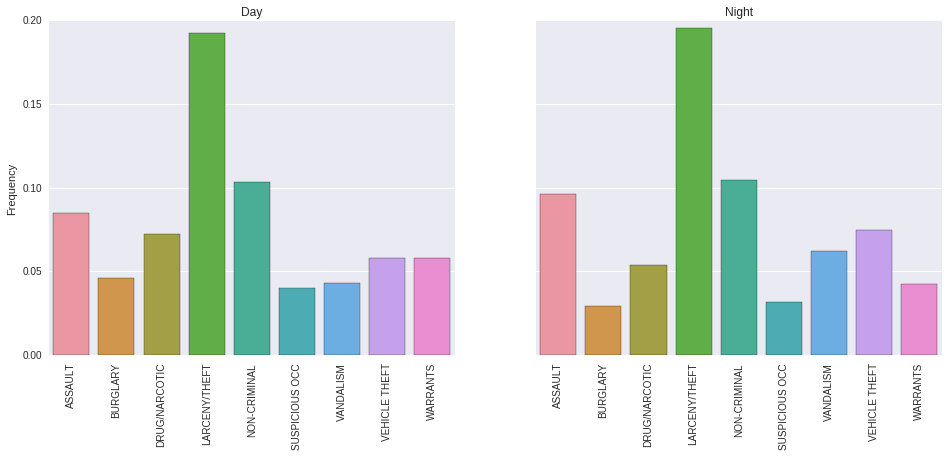

In [47]:
train_subset = get_random_subset(train)
train_subset["NightOrDay"] = train_subset["Hour"].apply(isNight)
most_common_cats = train_subset.Category[train_subset.Category != "OTHER OFFENSES"].value_counts().index[0:9]

counts = train_subset.NightOrDay.value_counts().index

f, axtuple = plt.subplots(1, len(counts), sharey=True)


for i, day in enumerate(counts):
    
    subset = train_subset[train_subset.NightOrDay == day]
    proportions = (subset.Category.value_counts().astype(float) / len(subset)).loc[most_common_cats]
    proportions = proportions.sort_index()
    
    ax = sns.barplot(x=proportions.index, y=proportions, ax=axtuple[i])
    ax.set_title(day)
    ax.set_ylabel("")
    plt.sca(ax)
    plt.xticks(rotation=90)
    
axtuple[0].set_ylabel("Frequency")
plt.gcf().set_size_inches(16, 6, forward=True)

#Interesting to see how some crimes are more common during daytime than night.